# SRCNN

In [0]:
!pip install easycolab
import easycolab as ec
ec.mount()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Opening directory /content/gdrive/My Drive/
Done!


In [0]:
import torch
from torch import nn
import torch.utils.data as torch_data
from torchvision import transforms
from torchvision import models
import torchvision
from tqdm import tqdm
import numpy as np
import os
import random
import PIL
import matplotlib.pyplot as plt

## Create train/test sets

In [0]:
class create_set(torch_data.Dataset):
    def __init__(self, path_X, path_y,transform=None):
        super(create_set, self).__init__()
        #self.X=[str(i+1)+'.png' for i in range(len(os.listdir(path_X)))][6:]
        #self.y=[str(i+1)+'.png' for i in range(len(os.listdir(path_y)))][6:]
        
        self.X=sorted(os.listdir(path_X))[6:]
        self.y=sorted(os.listdir(path_y))[6:]
        self.transform=transform
        self.path_X=path_X
        self.path_y=path_y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        X=PIL.Image.open(os.path.join(self.path_X,self.X[idx])).crop((0, 138, 768, 906.0)).resize((256,256)) 
        y=PIL.Image.open(os.path.join(self.path_y,self.y[idx])).crop((0, 138, 768, 906.0)).resize((256,256)) 
        if self.transform is not None:
            rand=np.random.randint(10**9)
            random.seed(rand)
            X=self.transform(X)
            random.seed(rand)
            y=self.transform(y)
        return X, y

In [0]:
train_set=create_set('./bia_proj/data/trainX/', './bia_proj/data/trainY/', transform=transforms.Compose([
        transforms.ToTensor()
        ]))

In [0]:
class create_set(torch_data.Dataset):
    def __init__(self, path_X, path_y,transform=None):
        super(create_set, self).__init__()
        #self.X=[str(i+1)+'.png' for i in range(len(os.listdir(path_X)))][5:6]
        #self.y=[str(i+1)+'.png' for i in range(len(os.listdir(path_y)))][5:6]        
        self.X=sorted(os.listdir(path_X))[5:6]
        self.y=sorted(os.listdir(path_y))[5:6]
        self.transform=transform
        self.path_X=path_X
        self.path_y=path_y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        X=PIL.Image.open(os.path.join(self.path_X,self.X[idx])).crop((0, 138, 768, 906.0)).resize((256,256)) 
        y=PIL.Image.open(os.path.join(self.path_y,self.y[idx])).crop((0, 138, 768, 906.0)).resize((256,256)) 
        if self.transform is not None:
            rand=np.random.randint(10**9)
            random.seed(rand)
            X=self.transform(X)
            random.seed(rand)
            y=self.transform(y)
        return X, y

In [0]:
test_set=create_set('./bia_proj/data/trainX/', './bia_proj/data/trainY/', 
                    transform=transforms.Compose([transforms.ToTensor()]))

In [0]:
train_loader = torch_data.DataLoader(train_set, batch_size=10, shuffle=True) 


In [0]:
test_loader = torch_data.DataLoader(test_set, batch_size=1, shuffle=False)

## Create model

In [0]:
import torch
import torch.nn as nn
from torch.autograd import Variable

In [0]:
class SRCnn(nn.Module):
    def __init__(self):
        super(SRCnn, self).__init__()
        self.conv1=nn.Conv2d(3, 64, kernel_size=9, padding=4)
        self.conv2=nn.Conv2d(64, 32, kernel_size=5, padding=2)
        self.conv3=nn.Conv2d(32, 3, kernel_size=5, padding=2)
        self.relu=nn.ReLU(inplace=True)
        self.sequential=nn.Sequential(self.conv1,
                                      nn.ReLU(inplace=True),
                                      self.conv2,
                                      nn.ReLU(inplace=True),
                                      self.conv3)

    def forward(self, x):
        x = self.sequential(x)
        return x

In [0]:
def train(epochs, net, criterion, optimizer, train_loader, test_loader,scheduler=None, verbose=True, save_dir=None):
    net.to(device)
    loss_train=[]
    loss_test=[]
    loss_min=100
    for epoch in tqdm(range(1, epochs+1)):
        net.train(True)
        for X, y in train_loader:
            X=X.to(device)
            y=y.to(device)
            model_output=net(X)
            loss=criterion(model_output, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        loss_train.append(loss)
        net.train(False)
        net.eval()
        for X, y in test_loader:
            X=X.to(device)
            y=y.to(device)
            model_output=net(X)
            test_loss=criterion(model_output, y)
        loss_test.append(test_loss)
        if scheduler is not None:
            scheduler.step()
        clear_output(True)
        plt.figure(figsize=(10,5))
        plt.subplot(1,2,1)
        plt.ylabel('Loss')
        plt.xlabel('epoch')
        plt.plot(loss_train, label='loss_train: {:.4f}'.format(loss_train[-1]))
        plt.plot(loss_test, label='loss_test: {:.4f}'.format(loss_test[-1]))
        plt.legend()
        plt.subplot(1,2,2)
        plt.title("Deblurred")
        plt.imshow(model_output.cpu().detach().numpy().transpose([0, 2, 3, 1])[0])    
        plt.show()
        if loss_min>loss:
            loss_min=loss
            torch.save(net.state_dict(), './bia_proj/srcnn/net.pth')

## Training model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


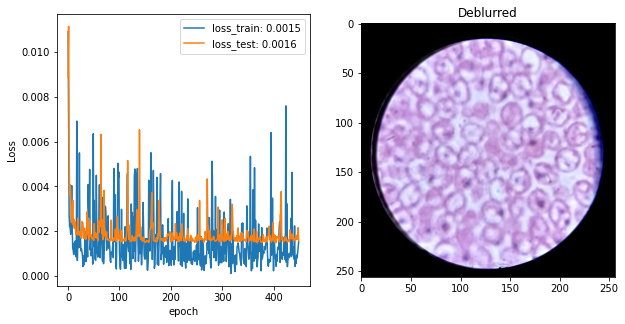

100%|██████████| 450/450 [1:03:55<00:00,  8.52s/it]


In [0]:
from IPython.display import clear_output

device='cuda:0'
net = SRCnn()
criterion=nn.MSELoss()
optimizer=torch.optim.Adam(net.parameters(), lr=0.001)
epochs = 450
train(epochs, net, criterion, optimizer, train_loader, test_loader)

In [0]:
net=SRCnn().to('cuda:0')
net.load_state_dict(torch.load('./bia_proj/srcnn/net.pth'))
net.eval()

SRCnn(
  (conv1): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (conv2): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu): ReLU(inplace=True)
  (sequential): Sequential(
    (0): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (3): ReLU(inplace=True)
    (4): Conv2d(32, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
)